In [1]:
import pandas as pd
import numpy as np
import pickle
import os

# --- CONFIGURATION ---

# This path is relative to where your notebook is currently saved.
BASE_PATH = 'data/WESAD/' 
subject_id = 'S2'

# Construct the full file path: data/WESAD/S2/S2.pkl
subject_file_path = os.path.join(BASE_PATH, subject_id, f'{subject_id}.pkl')

# --- LOADING DATA ---

print(f"Looking for file at: {subject_file_path}")

if os.path.exists(subject_file_path):
    print("File found! Loading data... (this might take a few seconds)")
    
    # We open the file in binary read mode ('rb')
    # 'latin1' encoding is required for these specific files
    with open(subject_file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
        
    print("Success! Data loaded.")
    print("-" * 30)
    
    # --- INSPECTION ---
    # Let's verify what we have inside
    print(f"Subject: {subject_id}")
    print(f"Data Keys: {data.keys()}")
    
else:
    print("Error: File not found.")
    print(f"Please check if the folder '{BASE_PATH}' exists correctly.")
    print(f"Current working directory: {os.getcwd()}")

Looking for file at: data/WESAD/S2\S2.pkl
File found! Loading data... (this might take a few seconds)
Success! Data loaded.
------------------------------
Subject: S2
Data Keys: dict_keys(['signal', 'label', 'subject'])


In [2]:
# 1. Extract the labels (what we want to predict)
labels = data['label']

# 2. View full size
print(f"1. How many data points are there in total? {labels.shape}")

# 3. See what the values are (0, 1, 2...?)
# np.unique shows us the list of values ​​without repetitions.
unique_values = np.unique(labels)
print(f"2. What states (labels) exist? {unique_values}")

1. How many data points are there in total? (4255300,)
2. What states (labels) exist? [0 1 2 3 4 6 7]


In [3]:
# 1. Extract Chest data
# We create a shortcut variable to avoid typing "data['signal']['chest']" every time
chest_signals = data['signal']['chest']
labels = data['label']

# 2. Create a dictionary to construct the DataFrame
# We use .flatten() to convert the arrays from shape (N, 1) to shape (N,)
# This ensures pandas treats them as simple lists of numbers.
data_dict = {
    'ECG': chest_signals['ECG'].flatten(),
    'EDA': chest_signals['EDA'].flatten(),
    'EMG': chest_signals['EMG'].flatten(),
    'Resp': chest_signals['Resp'].flatten(),
    'Temp': chest_signals['Temp'].flatten(),
    'ACC_x': chest_signals['ACC'][:, 0], # Accelerometer X-axis
    'ACC_y': chest_signals['ACC'][:, 1], # Accelerometer Y-axis
    'ACC_z': chest_signals['ACC'][:, 2], # Accelerometer Z-axis
    'label': labels.flatten()            # The outcome we want to predict
}

# 3. Create the DataFrame
df_raw = pd.DataFrame(data_dict)

# 4. Verify the output
print("DataFrame created successfully!")
print(f"Dimensions: {df_raw.shape}") # Expected: (4255300, 9)

# Show the first 5 rows
display(df_raw.head())

DataFrame created successfully!
Dimensions: (4255300, 9)


,ECG,EDA,EMG,Resp,Temp,ACC_x,ACC_y,ACC_z,label
0,0.021423,5.250549,-0.004440,-1.148987,30.120758,0.9554,-0.2220,-0.5580,0
1,0.020325,5.267334,0.004349,-1.124573,30.129517,0.9258,-0.2216,-0.5538,0
2,0.016525,5.243301,0.005173,-1.152039,30.138214,0.9082,-0.2196,-0.5392,0
3,0.016708,5.249405,0.007187,-1.158142,30.129517,0.8974,-0.2102,-0.5122,0
4,0.011673,5.286407,-0.015152,-1.161194,30.130951,0.8882,-0.2036,-0.4824,0


In [4]:
df_raw['label'].unique()


array([0, 1, 2, 6, 4, 3, 7], dtype=int32)

In [5]:
# --- STEP 1: FILTERING ---

# We only want Baseline (1) and Stress (2)
# We create a new DataFrame called 'df_filtered' to keep the original raw data safe
df_filtered = df_raw[df_raw['label'].isin([1, 2])].copy()

# Check how many rows we have left
print(f"Original rows: {len(df_raw)}")
print(f"Filtered rows: {len(df_filtered)}")

# --- STEP 2: REMAPPING LABELS ---

# Current state: 1 = Baseline, 2 = Stress
# Goal state:    0 = No Stress, 1 = Stress (Standard Binary Classification)

label_mapping = {
    1: 0,  # Baseline becomes class 0
    2: 1   # Stress becomes class 1
}

df_filtered['label'] = df_filtered['label'].map(label_mapping)

# --- STEP 3: VERIFICATION ---

print("-" * 30)
print(f"Unique labels in filtered data: {df_filtered['label'].unique()}")
print("Count per class:")
print(df_filtered['label'].value_counts())

Original rows: 4255300
Filtered rows: 1231300
------------------------------
Unique labels in filtered data: [0 1]
Count per class:
label
0    800800
1    430500
Name: count, dtype: int64


In [6]:
# --- DOWNSAMPLING (AGGREGATION) ---

# 1. Convert Index to Real Time (Seconds)
# Since the sampling rate is 700 Hz, every 700 rows = 1 second.
# We create a new column 'Time_Sec' representing the exact time in seconds.
df_filtered['Time_Sec'] = df_filtered.index / 700.0

# 2. Create a Grouping Key
# We want to group data by each second. We convert the precise time (e.g., 1.45s)
# to an integer (e.g., 1s). This creates "bins" for our groups.
df_filtered['Time_Group'] = df_filtered['Time_Sec'].astype(int)

# 3. Aggregate Data (Calculate Mean)
# We group by the 'Time_Group' and calculate the mean for all columns (ECG, EDA, etc.)
# This compresses 700 rows into 1 row representing that second.
df_agg = df_filtered.groupby('Time_Group').mean()

# 4. Fix the Label Column
# Since we averaged the labels, we might get values like 0.99 or 0.01.
# We round them back to 0 or 1 to keep our classification binary.
df_agg['label'] = df_agg['label'].round().astype(int)

# --- STEP 5: VERIFICATION ---

print("-" * 30)
print("Downsampling complete!")
print(f"Rows BEFORE (Raw 700Hz): {len(df_filtered)}")
print(f"Rows AFTER (Aggregated 1Hz): {len(df_agg)}")

print("\nFirst 5 rows of the new dataset:")
display(df_agg.head())

------------------------------
Downsampling complete!
Rows BEFORE (Raw 700Hz): 1231300
Rows AFTER (Aggregated 1Hz): 1761

First 5 rows of the new dataset:


,ECG,EDA,EMG,Resp,Temp,ACC_x,ACC_y,ACC_z,label,Time_Sec
Time_Group,,,,,,,,,,
306,0.076428,5.684432,-0.002314,-0.473157,29.125105,0.885016,-0.109039,-0.254880,0,306.772857
307,0.022615,5.580099,-0.002840,-1.032288,29.133156,0.882779,-0.121541,-0.257501,0,307.499286
308,-0.025130,5.496317,-0.002691,0.419909,29.138432,0.878834,-0.129997,-0.271099,0,308.499286
309,0.005718,5.414110,-0.002774,1.917140,29.145496,0.874536,-0.135453,-0.280483,0,309.499286
310,0.028033,5.371765,-0.002678,2.677695,29.148165,0.877762,-0.121207,-0.276895,0,310.499286


In [7]:
# --- STEP 1: PRE-CALCULATION (Feature Engineering) ---

# Calculate Accelerometer Magnitude
# We combine the 3 axes (X, Y, Z) into a single measure of "Total Movement Intensity".
# This helps the model distinguish between physical activity and stress.
df_filtered['ACC_Mag'] = (df_filtered['ACC_x']**2 + df_filtered['ACC_y']**2 + df_filtered['ACC_z']**2)**0.5

# --- STEP 2: DEFINE AGGREGATION RULES ---

# Define a custom function for Amplitude (Range)
def amp(x):
    return x.max() - x.min()

# We define a dictionary telling Pandas which statistics to calculate for each sensor.
# Note: We removed ACC_x, ACC_y, ACC_z because we are using the superior ACC_Mag.
aggregations = {
    'ECG': ['mean', 'std', 'min', 'max', amp],
    'EDA': ['mean', 'std', 'min', 'max', amp],
    'EMG': ['mean', 'std', 'min', 'max', amp],
    'Resp':['mean', 'std', 'min', 'max', amp],
    'Temp':['mean', 'std', 'min', 'max', amp],
    'ACC_Mag': ['mean', 'std', 'min', 'max', amp], # Our new "super feature"
    'label': ['mean'] # The label is just averaged (to be rounded later)
}

# --- STEP 3: EXECUTE DOWNSAMPLING ---

# 1. Convert Index to Real Time (Seconds)
# Dividing by 700 converts the row number to seconds.
df_filtered['Time_Sec'] = df_filtered.index / 700.0

# 2. Create the Grouping Key
# We cast to integer to group everything happening within the same second (e.g., 1.1s -> 1).
df_filtered['Time_Group'] = df_filtered['Time_Sec'].astype(int)

# 3. Apply the Aggregation
print("Processing advanced statistics (this might take a few seconds)...")
df_feat = df_filtered.groupby('Time_Group').agg(aggregations)

# --- STEP 4: CLEANUP & FORMATTING ---

# Pandas creates a Multi-Index (hierarchical columns) like ('ECG', 'mean').
# We flatten this to simple names like 'ECG_mean', 'ECG_std'.
df_feat.columns = ['_'.join(col).strip() for col in df_feat.columns.values]

# Fix the Label Column name (it became 'label_mean')
df_feat.rename(columns={'label_mean': 'label'}, inplace=True)

# Round the label back to 0 or 1 (Binary Class)
df_feat['label'] = df_feat['label'].round().astype(int)

# --- RESULT VERIFICATION ---
print("-" * 30)
print(f"New Feature Columns: {df_feat.shape[1]}")
print(f"Final Row Count: {len(df_feat)}")
display(df_feat.head())

Processing advanced statistics (this might take a few seconds)...
------------------------------
New Feature Columns: 31
Final Row Count: 1761


,ECG_mean,ECG_std,ECG_min,ECG_max,ECG_amp,EDA_mean,EDA_std,EDA_min,EDA_max,EDA_amp,...,Temp_std,Temp_min,Temp_max,Temp_amp,ACC_Mag_mean,ACC_Mag_std,ACC_Mag_min,ACC_Mag_max,ACC_Mag_amp,label
Time_Group,,,,,,,,,,,,,,,,,,,,,
306,0.076428,0.027643,0.016708,0.161270,0.144562,5.684432,0.021794,5.643845,5.756760,0.112915,...,0.026374,29.082184,29.246124,0.163940,0.927584,0.007450,0.910847,0.942985,0.032139,0
307,0.022615,0.161117,-0.217850,0.820587,1.038437,5.580099,0.040534,5.521011,5.671692,0.150681,...,0.029365,29.086487,29.264862,0.178375,0.927857,0.010262,0.900502,0.959531,0.059028,0
308,-0.025130,0.124100,-0.215744,0.704544,0.920288,5.496317,0.022475,5.310822,5.564117,0.253296,...,0.030485,29.095123,29.287872,0.192749,0.928909,0.007025,0.901548,0.958807,0.057259,0
309,0.005718,0.095722,-0.174042,0.598984,0.773026,5.414110,0.023397,5.355453,5.518723,0.163269,...,0.028695,29.100861,29.277832,0.176971,0.928378,0.004182,0.916114,0.940910,0.024796,0
310,0.028033,0.146509,-0.182190,0.979294,1.161484,5.371765,0.012208,5.332947,5.431366,0.098419,...,0.027921,29.103729,29.299408,0.195679,0.928443,0.004720,0.916481,0.941047,0.024566,0


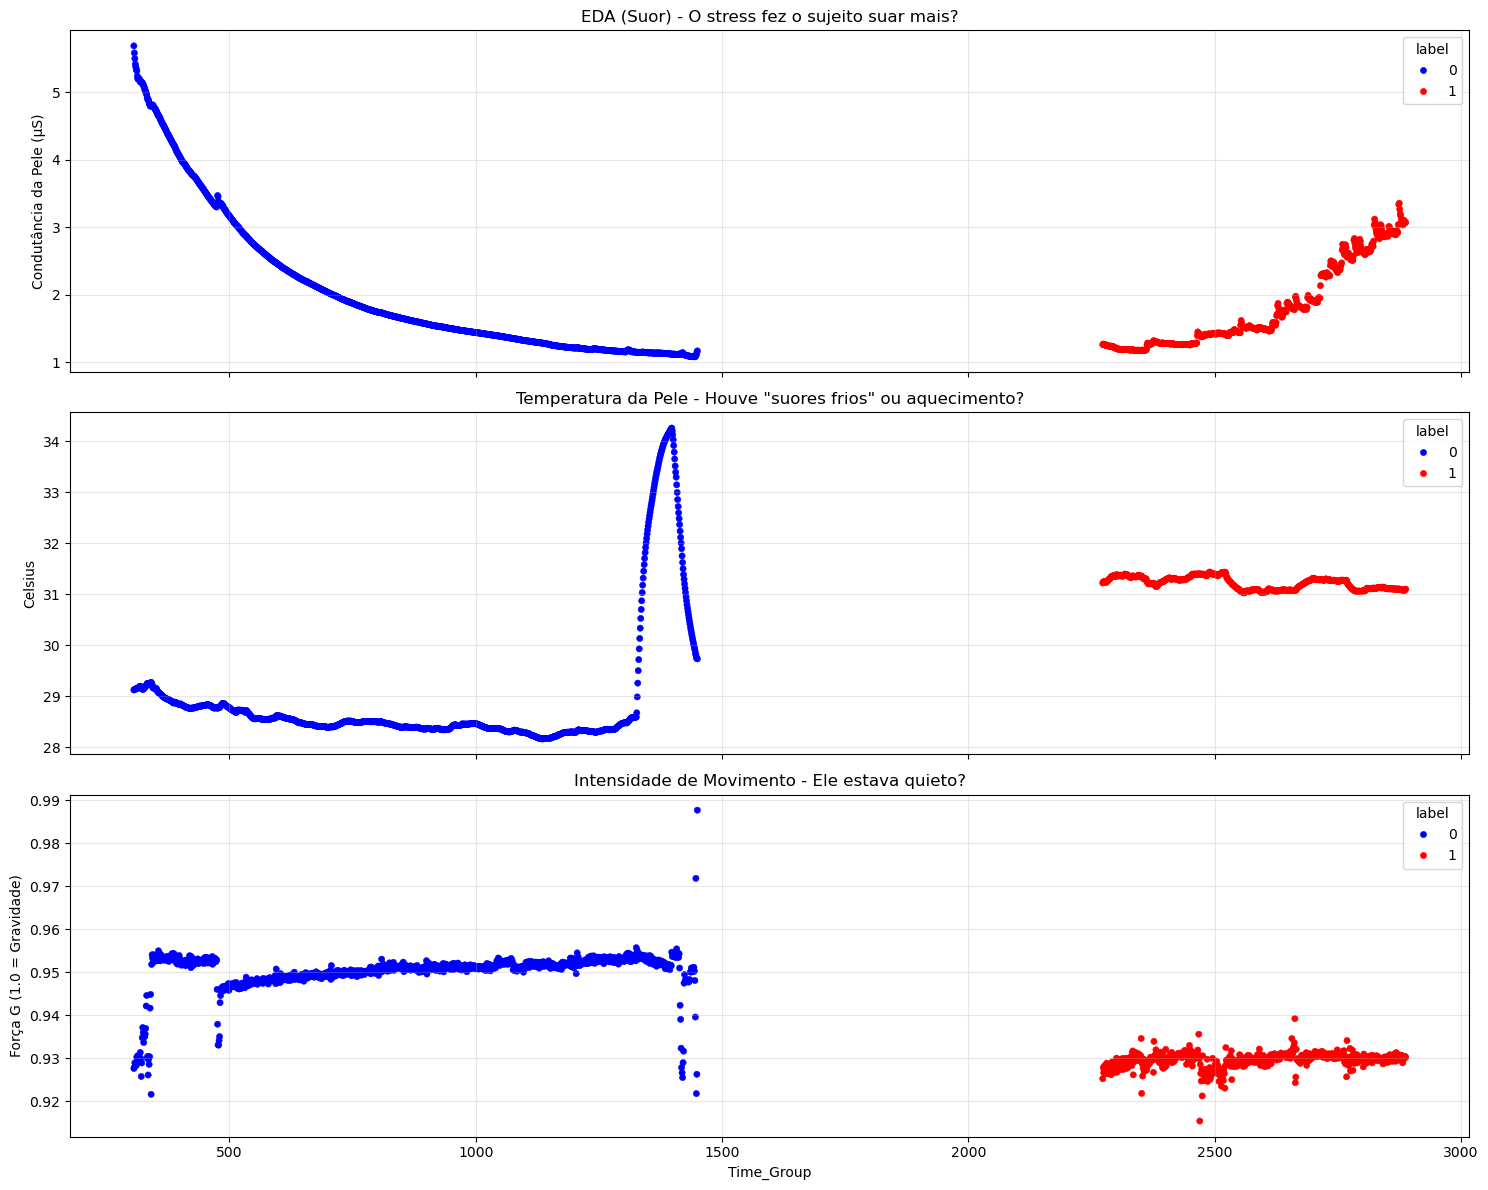

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- VISUALIZATION: THE STORY OF S2 ---

# Configurar a figura com 3 linhas (subplots)
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Cores: Azul para Baseline (Calma), Vermelho para Stress
colors = {0: 'blue', 1: 'red'}

# --- PLOT 1: EDA (Suor) ---
# Queremos ver se sobe durante o stress (vermelho)
sns.scatterplot(
    data=df_feat, x=df_feat.index, y='EDA_mean', hue='label', 
    palette=colors, s=20, ax=axes[0], edgecolor=None
)
axes[0].set_title('EDA (Suor) - O stress fez o sujeito suar mais?')
axes[0].set_ylabel('Condutância da Pele (µS)')
axes[0].grid(True, alpha=0.3)

# --- PLOT 2: Temperatura ---
# A temperatura da pele varia com o stress (vasoconstrição)
sns.scatterplot(
    data=df_feat, x=df_feat.index, y='Temp_mean', hue='label', 
    palette=colors, s=20, ax=axes[1], edgecolor=None
)
axes[1].set_title('Temperatura da Pele - Houve "suores frios" ou aquecimento?')
axes[1].set_ylabel('Celsius')
axes[1].grid(True, alpha=0.3)

# --- PLOT 3: Movimento (Acelerómetro) ---
# Fundamental: Queremos ver POUCO movimento no stress (para provar que não estava a correr)
sns.scatterplot(
    data=df_feat, x=df_feat.index, y='ACC_Mag_mean', hue='label', 
    palette=colors, s=20, ax=axes[2], edgecolor=None
)
axes[2].set_title('Intensidade de Movimento - Ele estava quieto?')
axes[2].set_ylabel('Força G (1.0 = Gravidade)')
axes[2].grid(True, alpha=0.3)

# Ajustes finais
plt.tight_layout()
plt.show()

In [9]:

# --- CONFIGURATION ---

# List of all WESAD subjects
# Note: S12 is usually excluded due to data quality issues, but included here if you have it.
subjects = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

# Helper function to calculate Amplitude (Range)
def amp(x):
    return x.max() - x.min()

# --- PROCESSING FUNCTION ---

def process_subject(subject_id):
    print(f"--> Processing {subject_id}...")
    
    # 1. Construct the file path
    # Assumes structure: data/WESAD/S2/S2.pkl
    file_path = os.path.join('data', 'WESAD', subject_id, f'{subject_id}.pkl')
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"    WARNING: File not found: {file_path}")
        return None

    # 2. Load Data
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')

    # 3. Organize Raw Data (Chest Signals)
    chest_signals = data['signal']['chest']
    labels = data['label']

    df = pd.DataFrame({
        'ECG': chest_signals['ECG'].flatten(),
        'EDA': chest_signals['EDA'].flatten(),
        'EMG': chest_signals['EMG'].flatten(),
        'Resp': chest_signals['Resp'].flatten(),
        'Temp': chest_signals['Temp'].flatten(),
        'ACC_x': chest_signals['ACC'][:, 0],
        'ACC_y': chest_signals['ACC'][:, 1],
        'ACC_z': chest_signals['ACC'][:, 2],
        'label': labels.flatten()
    })

    # 4. Filter Data (Baseline vs Stress only)
    # 1 = Baseline, 2 = Stress. We ignore others (0, 3, 4).
    df = df[df['label'].isin([1, 2])].copy()
    
    # Remap Labels to Binary (0 = Baseline, 1 = Stress)
    df['label'] = df['label'].map({1: 0, 2: 1})

    # 5. Feature Engineering (Pre-Aggregation)
    # Calculate Accelerometer Magnitude (Total Movement Intensity)
    df['ACC_Mag'] = (df['ACC_x']**2 + df['ACC_y']**2 + df['ACC_z']**2)**0.5

    # 6. Prepare for Downsampling (Aggregation)
    # Define aggregation rules (features to extract per sensor)
    aggregations = {
        'ECG': ['mean', 'std', 'min', 'max', amp],
        'EDA': ['mean', 'std', 'min', 'max', amp],
        'EMG': ['mean', 'std', 'min', 'max', amp],
        'Resp':['mean', 'std', 'min', 'max', amp],
        'Temp':['mean', 'std', 'min', 'max', amp],
        'ACC_Mag': ['mean', 'std', 'min', 'max', amp],
        'label': ['mean']
    }

    # Convert row index to seconds (700Hz sampling rate)
    df['Time_Sec'] = df.index / 700.0
    df['Time_Group'] = df['Time_Sec'].astype(int)

    # 7. Execute Downsampling
    # Group by second and calculate statistics
    df_feat = df.groupby('Time_Group').agg(aggregations)

    # 8. Final Cleanup
    # Flatten hierarchical column names (e.g., ('ECG', 'mean') -> 'ECG_mean')
    df_feat.columns = ['_'.join(col).strip() for col in df_feat.columns.values]
    
    # Fix Label column name and values
    df_feat.rename(columns={'label_mean': 'label'}, inplace=True)
    df_feat['label'] = df_feat['label'].round().astype(int)

    # CRITICAL: Add Subject ID column
    # This is required for Leave-One-Subject-Out validation later
    df_feat['subject'] = subject_id

    return df_feat

# --- MAIN LOOP ---

all_data = []

print("Starting batch processing...")

for subj in subjects:
    try:
        processed_df = process_subject(subj)
        if processed_df is not None:
            all_data.append(processed_df)
            print(f"    Success! {len(processed_df)} rows generated for {subj}.")
    except Exception as e:
        print(f"    ERROR processing {subj}: {e}")

# --- CONCATENATION & SAVING ---

print("-" * 30)
if len(all_data) > 0:
    # Combine all subjects into one big DataFrame
    df_total = pd.concat(all_data)
    
    print("Processing Complete!")
    print(f"Total Unified Dataset Size: {len(df_total)} rows")
    print(f"Total Columns: {df_total.shape[1]}")
    print(f"Subjects Included: {df_total['subject'].unique()}")
    
    # Save to CSV for future use
    output_filename = 'features_chest.csv'
    df_total.to_csv(output_filename, index=False) # index=False because we don't need the Time_Group in the CSV
    print(f"\nDataset saved to: {output_filename}")
    
    display(df_total.head())
else:
    print("No data was processed. Please check your file paths.")

Starting batch processing...
--> Processing S2...
    Success! 1761 rows generated for S2.
--> Processing S3...
    Success! 1782 rows generated for S3.
--> Processing S4...
    Success! 1795 rows generated for S4.
--> Processing S5...
    Success! 1845 rows generated for S5.
--> Processing S6...
    Success! 1832 rows generated for S6.
--> Processing S7...
    Success! 1828 rows generated for S7.
--> Processing S8...
    Success! 1841 rows generated for S8.
--> Processing S9...
    Success! 1827 rows generated for S9.
--> Processing S10...
    Success! 1907 rows generated for S10.
--> Processing S11...
    Success! 1862 rows generated for S11.
--> Processing S13...
    Success! 1846 rows generated for S13.
--> Processing S14...
    Success! 1857 rows generated for S14.
--> Processing S15...
    Success! 1863 rows generated for S15.
--> Processing S16...
    Success! 1855 rows generated for S16.
--> Processing S17...
    Success! 1906 rows generated for S17.
---------------------------

,ECG_mean,ECG_std,ECG_min,ECG_max,ECG_amp,EDA_mean,EDA_std,EDA_min,EDA_max,EDA_amp,...,Temp_min,Temp_max,Temp_amp,ACC_Mag_mean,ACC_Mag_std,ACC_Mag_min,ACC_Mag_max,ACC_Mag_amp,label,subject
Time_Group,,,,,,,,,,,,,,,,,,,,,
306,0.076428,0.027643,0.016708,0.161270,0.144562,5.684432,0.021794,5.643845,5.756760,0.112915,...,29.082184,29.246124,0.163940,0.927584,0.007450,0.910847,0.942985,0.032139,0,S2
307,0.022615,0.161117,-0.217850,0.820587,1.038437,5.580099,0.040534,5.521011,5.671692,0.150681,...,29.086487,29.264862,0.178375,0.927857,0.010262,0.900502,0.959531,0.059028,0,S2
308,-0.025130,0.124100,-0.215744,0.704544,0.920288,5.496317,0.022475,5.310822,5.564117,0.253296,...,29.095123,29.287872,0.192749,0.928909,0.007025,0.901548,0.958807,0.057259,0,S2
309,0.005718,0.095722,-0.174042,0.598984,0.773026,5.414110,0.023397,5.355453,5.518723,0.163269,...,29.100861,29.277832,0.176971,0.928378,0.004182,0.916114,0.940910,0.024796,0,S2
310,0.028033,0.146509,-0.182190,0.979294,1.161484,5.371765,0.012208,5.332947,5.431366,0.098419,...,29.103729,29.299408,0.195679,0.928443,0.004720,0.916481,0.941047,0.024566,0,S2


In [10]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27607 entries, 306 to 4235
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ECG_mean      27607 non-null  float64
 1   ECG_std       27607 non-null  float64
 2   ECG_min       27607 non-null  float64
 3   ECG_max       27607 non-null  float64
 4   ECG_amp       27607 non-null  float64
 5   EDA_mean      27607 non-null  float64
 6   EDA_std       27607 non-null  float64
 7   EDA_min       27607 non-null  float64
 8   EDA_max       27607 non-null  float64
 9   EDA_amp       27607 non-null  float64
 10  EMG_mean      27607 non-null  float64
 11  EMG_std       27607 non-null  float64
 12  EMG_min       27607 non-null  float64
 13  EMG_max       27607 non-null  float64
 14  EMG_amp       27607 non-null  float64
 15  Resp_mean     27607 non-null  float64
 16  Resp_std      27607 non-null  float64
 17  Resp_min      27607 non-null  float64
 18  Resp_max      27607 non-null  